1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

file_path = 'data/data_000637.txt' #im on windows, only way i found was to download it by hand

with open(file_path, 'r') as file:
    total_lines = sum(1 for line in file)
    
N = min(12000,total_lines)
df = pd.read_csv(file_path, nrows=N)

print(df)

       HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0         1     0          123  3869200167        2374        26
1         1     0          124  3869200167        2374        27
2         1     0           63  3869200167        2553        28
3         1     0           64  3869200167        2558        19
4         1     0           64  3869200167        2760        25
...     ...   ...          ...         ...         ...       ...
11995     1     0          139  3869200286        3251         0
11996     1     0           62  3869200286        3246         4
11997     1     0           58  3869200286        3246        11
11998     1     0           61  3869200286        3251        17
11999     1     0           59  3869200286        3248        16

[12000 rows x 6 columns]


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [6]:

max_bx_values = df[df['BX_COUNTER'] == df['BX_COUNTER'].max()]
min_bx_values = df[df['BX_COUNTER'] == df['BX_COUNTER'].min()]
x = max_bx_values['BX_COUNTER'].iloc[0] - min_bx_values['BX_COUNTER'].iloc[0]

print("number of BX in an ORBIT :",x)


number of BX in an ORBIT : 3563


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

*Hint:* introduce an offset to the absolute time such that the start of the data acquisition (i.e. the first entry) is zero.

In [19]:

time_unit_ns = 25 / 30 
bx_counter_ns = 25 


df['absolute_time_ns'] = (
    df['ORBIT_CNT'] * x * bx_counter_ns +
    df['BX_COUNTER'] * bx_counter_ns +
    df['TDC_MEAS'] * time_unit_ns
)


start_time = df['absolute_time_ns'].min()
df['absolute_time_ns'] -= start_time
df['absolute_time'] = pd.to_datetime(df['absolute_time_ns'], unit='ns')

print(df)


         HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
0           1     0          123  3869200167        2374        26   
1           1     0          124  3869200167        2374        27   
2           1     0           63  3869200167        2553        28   
3           1     0           64  3869200167        2558        19   
4           1     0           64  3869200167        2760        25   
...       ...   ...          ...         ...         ...       ...   
1310715     1     0           62  3869211171         762        14   
1310716     1     1            4  3869211171         763        11   
1310717     1     0           64  3869211171         764         0   
1310718     1     0          139  3869211171         769         0   
1310719     1     0           61  3869211171         762        18   

         absolute_time_ns                 absolute_time  
0            0.000000e+00 1970-01-01 00:00:00.000000000  
1            8.125000e-01 1970-01-01 00:00:

4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [20]:
duration = df['absolute_time'].max() - df['absolute_time'].min()
hours, remainder = divmod(duration.total_seconds(), 3600)
minutes, seconds = divmod(remainder, 60)

print("Duration of data:", hours,  " hours, ", minutes,  " minutes, ", seconds, " seconds")

Duration of data: 0.0  hours,  0.0  minutes,  0.980141  seconds


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [21]:
channel_counts = df.groupby(['FPGA', 'TDC_CHANNEL']).size().reset_index(name='count')
top_noisy_channels = channel_counts.nlargest(3, 'count')

print("top 3 noisy channels:")
print(top_noisy_channels[['FPGA', 'TDC_CHANNEL', 'count']])

top 3 noisy channels:
     FPGA  TDC_CHANNEL  count
123     0          139  75617
58      0           64  64581
57      0           63  63724


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [22]:
non_empty_orbits = df[df.groupby('ORBIT_CNT')['TDC_MEAS'].transform('count') > 0]
num_non_empty_orbits = non_empty_orbits['ORBIT_CNT'].nunique()

print("Non empty orbits number:" ,num_non_empty_orbits)

Non empty orbits number: 11001


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [23]:
filtered_df = df[(df['TDC_CHANNEL'] == 139) & (df.groupby('ORBIT_CNT')['TDC_MEAS'].transform('count') > 0)]
num_unique_orbits_channel_139 = filtered_df['ORBIT_CNT'].nunique()

print("number of unique orbits with at least one measurement from TDC_CHANNEL=139:", num_unique_orbits_channel_139)

number of unique orbits with at least one measurement from TDC_CHANNEL=139: 10976


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [24]:
grouped_counts = df.groupby(['FPGA', 'TDC_CHANNEL']).size().reset_index(name='count')

fpga1 = grouped_counts[grouped_counts['FPGA'] == 1].set_index('TDC_CHANNEL')['count']
fpga2 = grouped_counts[grouped_counts['FPGA'] == 0].set_index('TDC_CHANNEL')['count']


print("FPGA 1:")
print(fpga1.head())
print('\n', "FPGA 2:")
print(fpga2.head())

FPGA 1:
TDC_CHANNEL
1    28438
2    32669
3    21970
4    26403
5    15003
Name: count, dtype: int64

 FPGA 2:
TDC_CHANNEL
1    1215
2    1602
3    1493
4    2352
5    1432
Name: count, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

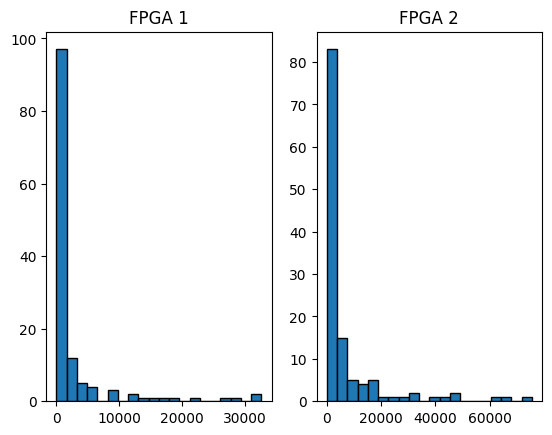

In [25]:

df_fpga1 = grouped_counts[grouped_counts['FPGA'] == 1]
df_fpga2 = grouped_counts[grouped_counts['FPGA'] == 0]

plt.subplot(1, 2, 1)
plt.hist(df_fpga1['count'], bins=20, edgecolor='black')
plt.title('FPGA 1')
plt.subplot(1, 2, 2)
plt.hist(df_fpga2['count'], bins=20, edgecolor='black')
plt.title('FPGA 2')
plt.show()